## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [2]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
import csv  
from io import BytesIO
from IPython import display

import torch
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
import h5py

from tensorflow.keras.layers import StringLookup

from ML_helper import *
from helpers.corrections import *
from helpers.image_loading import *
from helpers.handling import *
from helpers.identity_isolation import *

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

client = vision.ImageAnnotatorClient()

In [39]:
def ReturnFinalImage(image_in_bytes, client, padx=60, pady=30, verbose=False):
    # Initial prediction (including title and date) and ID bounding box.
    output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=verbose)

    # Returns the combined bounding box of the ID
    identity_box = combine_boxes(character_boxes)

    padx = 100
    pady = 60
    # Reduce the image to just the ID
    reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

    # Mask and removes things surrounding the ID (white background, title and date etc,)
    masked_image = mask_and_remove(reduced_frame, verbose=verbose)

    # CLeans the image by clearing the border and removing small grains.
    final_image = remove_deltas(masked_image, width=10, padx=padx, pady=pady, verbose=verbose)

    return output_string, final_image

FCA-3√74-8/21/12


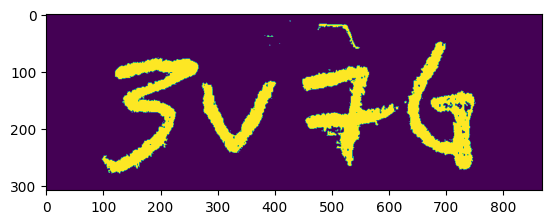

In [40]:
file = file_list[78]
image_in_bytes = RetreiveImage(file)
output_string, final_image = ReturnFinalImage(image_in_bytes, client)
plt.imshow(final_image)
print(output_string)

In [31]:
folders = ['Manually_Labelled/New/CA1208', 'Manually_Labelled/New/CA1207' ,'Manually_Labelled/New/CA1206','Manually_Labelled/New/CA1209jpegs JB']

bucket_name = "guppy_images"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

file_list = []
for folder in folders:
    s_file_list = storage_client.list_blobs(bucket_name,prefix=folder)
    s_file_list = [file.name for file in s_file_list]
    file_list.extend(s_file_list)

In [32]:
file_list

['Manually_Labelled/New/CA1208/FCA1B4K1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1B4P1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1B6R1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1G6V1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1G6W1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1K4V1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1K6K1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1K7B1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1K7V1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1K7W1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1K8W1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1O4K1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1O4O1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1O4P1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1O4W1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1O7G1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1P3K1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1P3O1208.JPG',
 'Manually_Labelled/New/CA1208/FCA1P3Y1208s.JPG',
 'Manually_Labelled/New/CA1208/FCA1P5V1208.JPG',
 'Manually_

In [33]:
def extract_ID(file_list):
    
    id_list = []
    for f in file_list:
        f = f.split('/')[-1].split('.')[0]

        title = f[:3]
        date = f[-4:]
        id = f[3:-4]
        id_list.append(id)

    return id_list

In [34]:
IDs = np.array(extract_ID(file_list))

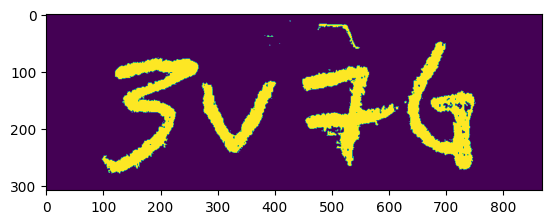

In [47]:
file = file_list[78]
image_in_bytes = RetreiveImage(file)
output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

label_ID = IDs[78]

plt.imshow(im_ID)

In [48]:
file_list[78]

'Manually_Labelled/New/CA1208/FCA3V7G1208s.JPG'

In [49]:
image_width, image_height = 256, 64

In [50]:
characters = []
for i in IDs:
    for j in i:
        if j not in characters:
            characters.append(j)

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

max_len = len(max(IDs, key=len))

In [51]:
model = tf.keras.Sequential()
model.add(char_to_num)
model.add(num_to_char)
model.build(input_shape=(1,1))
model.save('stringlookups.h5') #need to save these lookup tables for use in model.

/Users/jordan/anaconda3/envs/Guppies/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
model = tf.keras.models.load_model('stringlookups.h5');

char_to_num = model.layers[0]
num_to_char = model.layers[1]

In [53]:
vectorize_label(label_ID, char_to_num, max_len=max_len, padding_token=99).numpy()[None]

array([[14,  9, 11,  8,  1,  0,  0,  0]])

In [54]:
# # h5f.close()
# h5f = h5py.File(('dataset.h5'), 'w')

# image_width, image_height = 256, 64
   
# first_image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
# first_label = vectorize_label(label_ID, char_to_num, max_len=max_len, padding_token=99).numpy()[None]

# h5f.create_dataset('images', data=first_image, compression="gzip", chunks=True, maxshape=(None,image_height,image_width))
# h5f.create_dataset('labels', data=first_label, compression="gzip", chunks=True, maxshape=(None,max_len))


In [55]:
# some_im_IDs = []
# some_label_IDs = []

# idx = np.arange(0, len(file_list))
# np.random.shuffle(idx)


# for i in range(len(file_list)):
#     st = str(i)
#     try: 
#         frame, para_box = GetImageAndParaBox(file_list[idx[i]], client = client, verbose=False)
#         im_ID = extract_ID_handwriting(frame, para_box, verbose=False)


#         image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
#         label = vectorize_label(IDs[idx[i]], char_to_num, max_len=max_len, padding_token=99).numpy()[None]

#         h5f['images'].resize((h5f['images'].shape[0] + 1),axis=0)
#         h5f['images'][-1:] = image

#         h5f['labels'].resize((h5f['labels'].shape[0] + 1),axis=0)
#         h5f['labels'][-1:] = label

#         # some_im_IDs.append(im_ID)
#         # some_label_IDs.append(IDs[idx[i]])
#         st += ' success'

#     except: st += ' fail'
#     print(st)

# h5f.close()
    

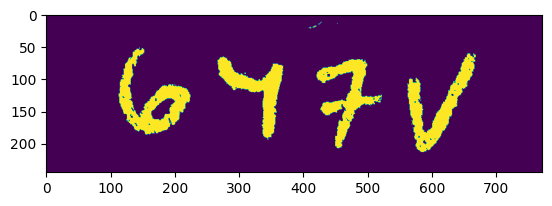

In [57]:
file = file_list[209]
image_in_bytes = RetreiveImage(file)
output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

plt.imshow(im_ID)

In [58]:
new_files = ListAvaliableFiles("guppy_images", "Manually_Labelled/New")
new_jpg_files = [ x for x in new_files if "JPG" in x ]

np.random.shuffle(new_jpg_files)

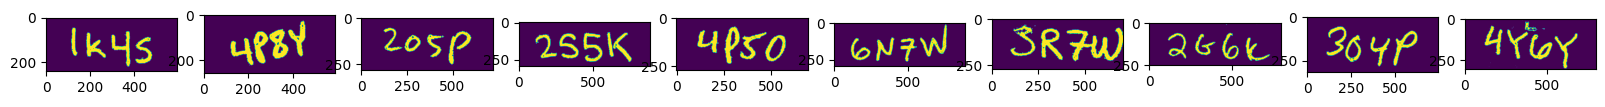

In [61]:
client = vision.ImageAnnotatorClient()

fig,ax = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    image_in_bytes = RetreiveImage(new_jpg_files[i])
    try:
        output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)
        ax[i].imshow(im_ID)
        # ax[i//10, i%10].imshow(ID)
        # ax[i//10, i%10].set_title('Index: %i' %i)
    except:
        pass

# plt.tight_layout()

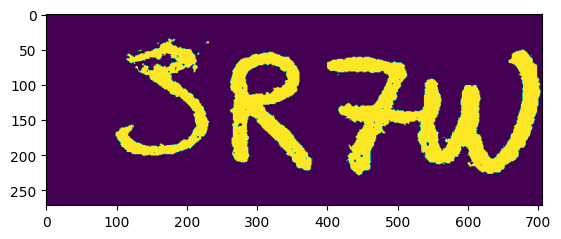

In [63]:
file = new_jpg_files[6]
image_in_bytes = RetreiveImage(file)

output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

plt.imshow(im_ID)
# print(file)

## Lets isolate single characters

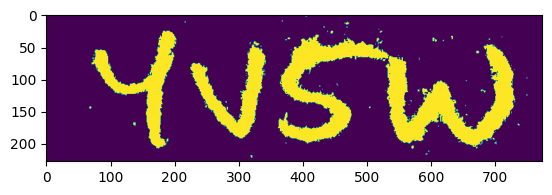

In [64]:
plt.imshow(ID)

In [65]:
num_components, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(ID))

In [66]:
rel_components = np.where(stats[:,-1] >800)[0][1:]

In [67]:
stats = stats[rel_components]

# stats = np.sort(stats, axis=0) #sort by their x coordinate to get in right order

In [68]:
characters = []
pad = 10

for i in range(rel_components.shape[0]):

    y_start,x_start,width,height = stats[i,:4]

    char = labels[x_start-pad:x_start+height+pad,y_start-pad:y_start+width+pad] == rel_components[i]

    characters.append(char)

print(characters)
characters = np.array(characters)
characters = characters[np.argsort(stats[:,0])]
fig,ax = plt.subplots(1,rel_components.shape[0],figsize=(10,5))
for i in range(rel_components.shape[0]):
    ax[i].imshow(characters[i])
    ax[i].axis('off')

[array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

### now need to pad somewhat and get into 28$\times$28 format

In [69]:
samples = torch.zeros((len(characters), 1, 28, 28))

for i, char in enumerate(characters):


    #here we should really scale up if w and h are too small.
    h,w = char.shape
    pooler = torch.nn.AvgPool2d(10)

    
    eg = np.uint8(char)

    eg = cv2.dilate(eg, np.ones((5,5)), iterations = 1)

    if h>w:
        resize_h = 260
        resize_w = int(w * (resize_h/h))
        pad = (resize_h - resize_w)//2
        char = cv2.resize(np.uint8(char), (resize_w, resize_h)).astype(np.float32)

        char = torch.tensor(np.pad(char,((10,10),(pad,280-resize_w-pad)), mode = 'constant', constant_values = 0))
        
    else:
        resize_w = 260
        resize_h = int(h * (resize_w/w))
        pad = (resize_w - resize_h)//2
        char = cv2.resize(np.uint8(char), (resize_w, resize_h)).astype(np.float32)

        char = torch.tensor(np.pad(char,((pad,280-resize_h-pad),(10,10),), mode = 'constant', constant_values = 0))

    samples[i] = pooler(char.unsqueeze(0).unsqueeze(0))

samples = samples / torch.amax(samples, dim = (1,2,3), keepdim = True)

samples = samples* 255


In [70]:
cnn_let = torch.load('letter_model.pth')
cnn_num = torch.load('number_model.pth')

relevant_characters =  ['0','1','2','3','4','5','6','7','8','B','F','G','K','N','O','P','R','S','V','W','Y'] 

nums = relevant_characters[:9]
letters = relevant_characters[9:]

def preds_to_char(preds, chars):
    pred_idx = torch.max(preds, 1)[1].data.numpy().squeeze()
    return np.array([chars[i] for i in pred_idx])

FileNotFoundError: [Errno 2] No such file or directory: 'letter_model.pth'

In [71]:
letter_preds = cnn_let(samples[::2])[0]
number_preds = cnn_num(samples[1::2])[0]

letter_preds_decoded = preds_to_char(letter_preds, letters)
number_preds_decoded = preds_to_char(number_preds, nums)

a = len(number_preds_decoded)
b = len(letter_preds_decoded)
string = ''
for i in range(a):
    string += number_preds_decoded[i]
    string += letter_preds_decoded[i]
if b > a:
    string += letter_preds_decoded[-1]



fig,ax = plt.subplots(1,len(samples),figsize=(10,10))
for i in range(len(samples)):
    ax[i].imshow(samples[i,0],cmap='gray')
    ax[i].set_title(string[i])
    ax[i].axis('off')



NameError: name 'cnn_let' is not defined

In [ ]:
file = new_jpg_files[6]
image_in_bytes = RetreiveImage(file)

output_string, im_ID = ReturnFinalImage(image_in_bytes, client=client, verbose=False)

plt.imshow(im_ID)

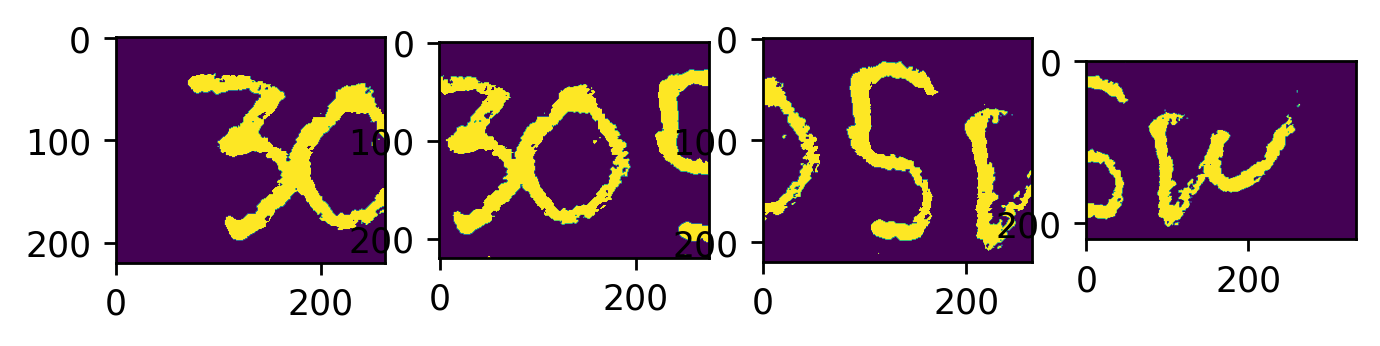

In [74]:
file = new_jpg_files[50]
image_in_bytes = RetreiveImage(file)

output_string, frame, para_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=False)

# ordered_para_boxes

fig,ax = plt.subplots(1,len(para_boxes),dpi=250)

for i, para_box in enumerate(para_boxes):
    box = combine_boxes([para_box])

    %matplotlib inline
    ID = extract_ID_handwriting(frame, box, verbose=False)
        
    ax[i].imshow(ID)

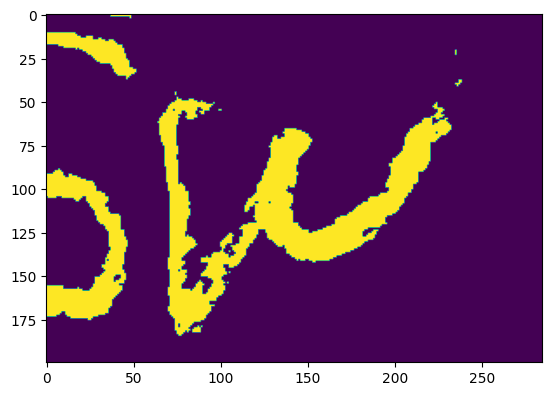

In [75]:
for n, row in enumerate(ID):
        if np.array_equal(row, np.zeros(len(row))):
            try:
                ID = np.delete(ID, n, axis=0)
            except:
                pass

for j, column in enumerate(np.transpose(ID)):
    if np.array_equal(column, np.zeros(len(column))):
        try:
            ID = np.delete(ID, j, axis=1)
        except:
            pass
        
plt.imshow(ID)